In [18]:
# Main
import os
import gc
import shutil
import time
import random
import cv2
import numpy as np 
import pandas as pd
import glob
from tqdm import tqdm
tqdm.pandas()
import re

# Data Visualization
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import plotly
import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots
from IPython.display import Image, display

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from torchvision.models import resnet18

import string
from tqdm.notebook import tqdm
import cv2
from PIL import Image
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import multiprocessing as mp


In [2]:
provinces = ["皖", "沪", "津", "渝", "冀", "晋", "蒙", "辽", "吉", "黑", "苏", "浙", "京", "闽", "赣", "鲁", "豫", "鄂", "湘", "粤", "桂", "琼", "川", "贵", "云", "藏", "陕", "甘", "青", "宁", "新", "警", "学", "O"]
alphabets = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'J', 'K', 'L', 'M', 'N', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W',
             'X', 'Y', 'Z', 'O']
ads = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'J', 'K', 'L', 'M', 'N', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X',
       'Y', 'Z', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', 'O']

# list_sub = ["ccpd_base", "ccpd_fn", "ccpd_db", "ccpd_rotate", "ccpd_weather", "ccpd_blur"]
list_sub = ["ccpd_weather"]
BASE_PATH = "C:/Users/User/DeepLearning/Deep_Learning/final_project"

In [3]:
# Create Metadata
def extract_plate_number(plate_number):
    chi_let = provinces[int(plate_number.split("_")[0])]
    alp_let = alphabets[int(plate_number.split("_")[1])]
    alp_num_let = plate_number.split("_")[2:]
    alp_num_let = "".join([ads[int(char)] for char in alp_num_let])
    all_let = chi_let + alp_let + alp_num_let
    return all_let
metadata_list = []

# Iterate over subdirectories
for sub in list_sub:
    sub_path = os.path.join(BASE_PATH, sub)
    sub_files = glob.glob(os.path.join(sub_path, "*"))

    # Append a dictionary for each file in the subdirectory
    for file_path in sub_files:
        # Extracting values
        detail = file_path.split("/")[-1].split("-")[2]
        bbox = detail.split("_")[0]
        x1_bbox, y1_bbox = map(int, bbox.split(","))
        x2_bbox, y2_bbox = map(int, detail.split("_")[1].split(","))

      

        # Extracting plate number
        plate_number = file_path.split("-")[4]

        # Create a dictionary for each file
        metadata_dict = {
            "image_path": file_path,
            "sub": sub,
            "x1_bbox": x1_bbox,
            "y1_bbox": y1_bbox,
            "x2_bbox": x2_bbox,
            "y2_bbox": y2_bbox,
            
        }

        # Add more columns to metadata_dict if needed
        metadata_dict["decoded_plate_number"] = extract_plate_number(plate_number)

        # Append the dictionary to the list
        metadata_list.append(metadata_dict)

# Create DataFrame from the list of dictionaries
df_metadata = pd.DataFrame(metadata_list)

# Display the DataFrame
df_metadata = df_metadata[:5500] 
df_metadata

,image_path,sub,x1_bbox,y1_bbox,x2_bbox,y2_bbox,decoded_plate_number
0,C:/Users/User/DeepLearning/Deep_Learning/final...,ccpd_weather,294,496,374,540,皖AD130W
1,C:/Users/User/DeepLearning/Deep_Learning/final...,ccpd_weather,304,542,411,577,皖AUT267
2,C:/Users/User/DeepLearning/Deep_Learning/final...,ccpd_weather,339,547,444,583,皖MZ4882
3,C:/Users/User/DeepLearning/Deep_Learning/final...,ccpd_weather,177,511,268,553,皖AVD028
4,C:/Users/User/DeepLearning/Deep_Learning/final...,ccpd_weather,402,426,497,467,皖RL222P
...,...,...,...,...,...,...,...
5495,C:/Users/User/DeepLearning/Deep_Learning/final...,ccpd_weather,96,584,372,688,皖AR8T97
5496,C:/Users/User/DeepLearning/Deep_Learning/final...,ccpd_weather,265,514,533,621,皖AL6M60
5497,C:/Users/User/DeepLearning/Deep_Learning/final...,ccpd_weather,282,536,566,637,皖A576X9
5498,C:/Users/User/DeepLearning/Deep_Learning/final...,ccpd_weather,64,606,309,723,皖ALF155


In [4]:
df_metadata['xmid'] = (df_metadata['x1_bbox'] + df_metadata['x2_bbox']) / (2*720)
df_metadata['ymid'] = (df_metadata['y1_bbox'] + df_metadata['y2_bbox']) / (2*1160)

df_metadata['bb_width'] = (df_metadata['x2_bbox'] - df_metadata['x1_bbox']) / 720
df_metadata['bb_height'] = (df_metadata['y2_bbox'] - df_metadata['y1_bbox']) / 1160

df_metadata

,image_path,sub,x1_bbox,y1_bbox,x2_bbox,y2_bbox,decoded_plate_number,xmid,ymid,bb_width,bb_height
0,C:/Users/User/DeepLearning/Deep_Learning/final...,ccpd_weather,294,496,374,540,皖AD130W,0.463889,0.446552,0.111111,0.037931
1,C:/Users/User/DeepLearning/Deep_Learning/final...,ccpd_weather,304,542,411,577,皖AUT267,0.496528,0.482328,0.148611,0.030172
2,C:/Users/User/DeepLearning/Deep_Learning/final...,ccpd_weather,339,547,444,583,皖MZ4882,0.543750,0.487069,0.145833,0.031034
3,C:/Users/User/DeepLearning/Deep_Learning/final...,ccpd_weather,177,511,268,553,皖AVD028,0.309028,0.458621,0.126389,0.036207
4,C:/Users/User/DeepLearning/Deep_Learning/final...,ccpd_weather,402,426,497,467,皖RL222P,0.624306,0.384914,0.131944,0.035345
...,...,...,...,...,...,...,...,...,...,...,...
5495,C:/Users/User/DeepLearning/Deep_Learning/final...,ccpd_weather,96,584,372,688,皖AR8T97,0.325000,0.548276,0.383333,0.089655
5496,C:/Users/User/DeepLearning/Deep_Learning/final...,ccpd_weather,265,514,533,621,皖AL6M60,0.554167,0.489224,0.372222,0.092241
5497,C:/Users/User/DeepLearning/Deep_Learning/final...,ccpd_weather,282,536,566,637,皖A576X9,0.588889,0.505603,0.394444,0.087069
5498,C:/Users/User/DeepLearning/Deep_Learning/final...,ccpd_weather,64,606,309,723,皖ALF155,0.259028,0.572845,0.340278,0.100862


In [5]:
# Train : 5000 (ccpd_base), Val and Test : 50 for each sub (except ccpd_base)
list_split = ["train"] * 5000
for i in range(5):
    list_split.extend(["val"]*50)
    list_split.extend(["test"]*50)
df_metadata["split"] = list_split
df_metadata

,image_path,sub,x1_bbox,y1_bbox,x2_bbox,y2_bbox,decoded_plate_number,xmid,ymid,bb_width,bb_height,split
0,C:/Users/User/DeepLearning/Deep_Learning/final...,ccpd_weather,294,496,374,540,皖AD130W,0.463889,0.446552,0.111111,0.037931,train
1,C:/Users/User/DeepLearning/Deep_Learning/final...,ccpd_weather,304,542,411,577,皖AUT267,0.496528,0.482328,0.148611,0.030172,train
2,C:/Users/User/DeepLearning/Deep_Learning/final...,ccpd_weather,339,547,444,583,皖MZ4882,0.543750,0.487069,0.145833,0.031034,train
3,C:/Users/User/DeepLearning/Deep_Learning/final...,ccpd_weather,177,511,268,553,皖AVD028,0.309028,0.458621,0.126389,0.036207,train
4,C:/Users/User/DeepLearning/Deep_Learning/final...,ccpd_weather,402,426,497,467,皖RL222P,0.624306,0.384914,0.131944,0.035345,train
...,...,...,...,...,...,...,...,...,...,...,...,...
5495,C:/Users/User/DeepLearning/Deep_Learning/final...,ccpd_weather,96,584,372,688,皖AR8T97,0.325000,0.548276,0.383333,0.089655,test
5496,C:/Users/User/DeepLearning/Deep_Learning/final...,ccpd_weather,265,514,533,621,皖AL6M60,0.554167,0.489224,0.372222,0.092241,test
5497,C:/Users/User/DeepLearning/Deep_Learning/final...,ccpd_weather,282,536,566,637,皖A576X9,0.588889,0.505603,0.394444,0.087069,test
5498,C:/Users/User/DeepLearning/Deep_Learning/final...,ccpd_weather,64,606,309,723,皖ALF155,0.259028,0.572845,0.340278,0.100862,test


In [7]:
from numba import cuda
from GPUtil import showUtilization as gpu_usage

def free_gpu_cache():
    print("Initial GPU Usage")
    gpu_usage()                             

    torch.cuda.empty_cache()

    cuda.select_device(0)
    cuda.close()
    cuda.select_device(0)

    print("GPU Usage after emptying the cache")
    gpu_usage()

free_gpu_cache()

Initial GPU Usage
| ID | GPU | MEM |
------------------
|  0 |  0% |  0% |
GPU Usage after emptying the cache
| ID | GPU | MEM |
------------------
|  0 |  0% |  2% |


In [8]:
from ultralytics import YOLO
df_results = df_metadata[df_metadata["split"]=="test"].reset_index(drop=True)
df_results = df_results[["image_path", "sub", "decoded_plate_number", "x1_bbox", "y1_bbox", "x2_bbox", "y2_bbox"]]
df_results

,image_path,sub,decoded_plate_number,x1_bbox,y1_bbox,x2_bbox,y2_bbox
0,C:/Users/User/DeepLearning/Deep_Learning/final...,ccpd_weather,鄂AT2W80,176,497,455,595
1,C:/Users/User/DeepLearning/Deep_Learning/final...,ccpd_weather,皖AB967N,213,444,469,551
2,C:/Users/User/DeepLearning/Deep_Learning/final...,ccpd_weather,皖A25T29,257,384,525,486
3,C:/Users/User/DeepLearning/Deep_Learning/final...,ccpd_weather,皖AZW108,201,476,493,570
4,C:/Users/User/DeepLearning/Deep_Learning/final...,ccpd_weather,皖AZ2744,252,586,532,684
...,...,...,...,...,...,...,...
245,C:/Users/User/DeepLearning/Deep_Learning/final...,ccpd_weather,皖AR8T97,96,584,372,688
246,C:/Users/User/DeepLearning/Deep_Learning/final...,ccpd_weather,皖AL6M60,265,514,533,621
247,C:/Users/User/DeepLearning/Deep_Learning/final...,ccpd_weather,皖A576X9,282,536,566,637
248,C:/Users/User/DeepLearning/Deep_Learning/final...,ccpd_weather,皖ALF155,64,606,309,723


In [9]:
# Assuming you have already imported your YOLO class

# Instantiate the YOLO model
yolo_model = YOLO('C:/Users/User/runs/detect/train4/weights/best.pt')

# Move the model to CPU
yolo_model = yolo_model.to('cpu')

# Rest of your code remains the same
bbox_results = yolo_model.predict(list(df_results["image_path"]), verbose=False)
all_box_list = []
all_conf_list = []

for bbox_result in bbox_results:
    boxes = bbox_result.boxes
    box_list = []
    conf_list = []

    for box in boxes:
        box_data = box.data[0][:4]
        box_data = [int(x) for x in box_data]
        conf = round(float(box.conf), 2)

        if conf >= 0.5:
            box_list.append(box_data)
            conf_list.append(conf)

    all_box_list.append(box_list)
    all_conf_list.append(conf_list)

df_results["pred_bbox"] = all_box_list
df_results["confidence"] = all_conf_list
df_results


,image_path,sub,decoded_plate_number,x1_bbox,y1_bbox,x2_bbox,y2_bbox,pred_bbox,confidence
0,C:/Users/User/DeepLearning/Deep_Learning/final...,ccpd_weather,鄂AT2W80,176,497,455,595,"[[177, 493, 454, 597]]",[0.94]
1,C:/Users/User/DeepLearning/Deep_Learning/final...,ccpd_weather,皖AB967N,213,444,469,551,"[[212, 443, 469, 551]]",[0.94]
2,C:/Users/User/DeepLearning/Deep_Learning/final...,ccpd_weather,皖A25T29,257,384,525,486,"[[255, 385, 523, 487]]",[0.93]
3,C:/Users/User/DeepLearning/Deep_Learning/final...,ccpd_weather,皖AZW108,201,476,493,570,"[[198, 476, 490, 570]]",[0.93]
4,C:/Users/User/DeepLearning/Deep_Learning/final...,ccpd_weather,皖AZ2744,252,586,532,684,"[[255, 587, 529, 680]]",[0.95]
...,...,...,...,...,...,...,...,...,...
245,C:/Users/User/DeepLearning/Deep_Learning/final...,ccpd_weather,皖AR8T97,96,584,372,688,"[[95, 584, 372, 687]]",[0.93]
246,C:/Users/User/DeepLearning/Deep_Learning/final...,ccpd_weather,皖AL6M60,265,514,533,621,"[[268, 515, 530, 620]]",[0.95]
247,C:/Users/User/DeepLearning/Deep_Learning/final...,ccpd_weather,皖A576X9,282,536,566,637,"[[277, 534, 570, 638]]",[0.92]
248,C:/Users/User/DeepLearning/Deep_Learning/final...,ccpd_weather,皖ALF155,64,606,309,723,"[[62, 606, 307, 721]]",[0.94]


In [10]:
resnet = resnet18(pretrained=True)

c:\Users\User\anaconda3\envs\DeepLearning\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\User\anaconda3\envs\DeepLearning\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [155]:
df_train = df_metadata[df_metadata["split"]=="train"].reset_index(drop=True)
df_train = df_train[["image_path", "sub", "decoded_plate_number", "x1_bbox", "y1_bbox", "x2_bbox", "y2_bbox"]]
df_train

,image_path,sub,decoded_plate_number,x1_bbox,y1_bbox,x2_bbox,y2_bbox
0,C:/Users/User/DeepLearning/Deep_Learning/final...,ccpd_weather,皖AD130W,294,496,374,540
1,C:/Users/User/DeepLearning/Deep_Learning/final...,ccpd_weather,皖AUT267,304,542,411,577
2,C:/Users/User/DeepLearning/Deep_Learning/final...,ccpd_weather,皖MZ4882,339,547,444,583
3,C:/Users/User/DeepLearning/Deep_Learning/final...,ccpd_weather,皖AVD028,177,511,268,553
4,C:/Users/User/DeepLearning/Deep_Learning/final...,ccpd_weather,皖RL222P,402,426,497,467
...,...,...,...,...,...,...,...
4995,C:/Users/User/DeepLearning/Deep_Learning/final...,ccpd_weather,皖Q05275,182,507,459,605
4996,C:/Users/User/DeepLearning/Deep_Learning/final...,ccpd_weather,皖AJ0S21,258,493,437,645
4997,C:/Users/User/DeepLearning/Deep_Learning/final...,ccpd_weather,皖A52A41,387,485,566,637
4998,C:/Users/User/DeepLearning/Deep_Learning/final...,ccpd_weather,皖AV0600,146,519,423,617


In [153]:
df_val = df_metadata[df_metadata["split"]=="val"].reset_index(drop=True)
df_val = df_val[["image_path", "sub", "decoded_plate_number", "x1_bbox", "y1_bbox", "x2_bbox", "y2_bbox"]]
df_val

,image_path,sub,decoded_plate_number,x1_bbox,y1_bbox,x2_bbox,y2_bbox
0,C:/Users/User/DeepLearning/Deep_Learning/final...,ccpd_weather,皖AV5A99,219,504,473,611
1,C:/Users/User/DeepLearning/Deep_Learning/final...,ccpd_weather,皖ADX498,282,452,568,547
2,C:/Users/User/DeepLearning/Deep_Learning/final...,ccpd_weather,皖A317C2,153,523,439,618
3,C:/Users/User/DeepLearning/Deep_Learning/final...,ccpd_weather,浙HFP512,250,454,525,553
4,C:/Users/User/DeepLearning/Deep_Learning/final...,ccpd_weather,皖AF5177,155,439,447,532
...,...,...,...,...,...,...,...
245,C:/Users/User/DeepLearning/Deep_Learning/final...,ccpd_weather,皖AC5S38,273,359,547,463
246,C:/Users/User/DeepLearning/Deep_Learning/final...,ccpd_weather,皖AD301Z,328,469,564,590
247,C:/Users/User/DeepLearning/Deep_Learning/final...,ccpd_weather,皖AL0L10,309,543,583,647
248,C:/Users/User/DeepLearning/Deep_Learning/final...,ccpd_weather,皖A4Q664,273,416,535,525


In [157]:
class Dataset(Dataset):
    def __init__(self, dataframe):
        self.df_train = dataframe

    def __len__(self):
        return len(self.df_train)

    def __getitem__(self, index):
        train_path = self.df_train["image_path"][index]
        train_image = cv2.imread(train_path)
        train_image = cv2.cvtColor(train_image, cv2.COLOR_BGR2RGB)

        # Crop Image with Bounding Box
        image = train_image[self.df_train["y1_bbox"][index]:self.df_train["y2_bbox"][index],
                            self.df_train["x1_bbox"][index]:self.df_train["x2_bbox"][index]]

        text = self.df_train["decoded_plate_number"][index]

        # Apply transformations
        transformed_image = self.transform(image)

        return transformed_image, text

    def transform(self, image):
        transform_ops = transforms.Compose([
            transforms.ToPILImage(),
            transforms.Resize((50, 200)),
            transforms.ToTensor(),
            transforms.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225))
        ])
        return transform_ops(image)

In [162]:
# cpu_count = mp.cpu_count()
# print(cpu_count)

trainset = Dataset(df_train)
valset =  Dataset(df_val)

train_loader = DataLoader(trainset, batch_size=16, num_workers=0, shuffle=False)
test_loader = DataLoader(valset, batch_size=16, num_workers=0, shuffle=False)
print(len(train_loader))

313


In [163]:
image_batch, text_batch = next(iter(train_loader))
print(image_batch.size(), text_batch)

torch.Size([16, 3, 50, 200]) ('皖AD130W', '皖AUT267', '皖MZ4882', '皖AVD028', '皖RL222P', '皖AGC276', '皖AU0194', '皖AC880Y', '皖ATG568', '皖A41476', '皖AH8V95', '皖ATV235', '皖AJ7532', '皖AE0901', '皖QSW808', '皖A93853')


In [160]:
num_chars = 7
print(num_chars)
rnn_hidden_size = 256

7


In [118]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [143]:
class CRNN(nn.Module):
    
    def __init__(self, num_chars, rnn_hidden_size=256, dropout=0.1):
        
        super(CRNN, self).__init__()
        self.num_chars = num_chars
        self.rnn_hidden_size = rnn_hidden_size
        self.dropout = dropout
        
        # CNN Part 1
        resnet_modules = list(resnet.children())[:-3]
        self.cnn_p1 = nn.Sequential(*resnet_modules)
        
        # CNN Part 2
        self.cnn_p2 = nn.Sequential(
            nn.Conv2d(256, 256, kernel_size=(3,6), stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True)
        )
        self.linear1 = nn.Linear(1024, 256)
        
        # RNN
        self.rnn1 = nn.GRU(input_size=rnn_hidden_size, 
                            hidden_size=rnn_hidden_size,
                            bidirectional=True, 
                            batch_first=True)
        self.rnn2 = nn.GRU(input_size=rnn_hidden_size, 
                            hidden_size=rnn_hidden_size,
                            bidirectional=True, 
                            batch_first=True)
        self.linear2 = nn.Linear(self.rnn_hidden_size*2, num_chars)
        
        
    def forward(self, batch):
        
        batch = self.cnn_p1(batch)
        # print(batch.size()) # torch.Size([-1, 256, 4, 13])
        
        batch = self.cnn_p2(batch) # [batch_size, channels, height, width]
        # print(batch.size())# torch.Size([-1, 256, 4, 10])
        
        batch = batch.permute(0, 3, 1, 2) # [batch_size, width, channels, height]
        # print(batch.size()) # torch.Size([-1, 10, 256, 4])
         
        batch_size = batch.size(0)
        T = batch.size(1)
        batch = batch.view(batch_size, T, -1) # [batch_size, T==width, num_features==channels*height]
        # print(batch.size()) # torch.Size([-1, 10, 1024])
        
        batch = self.linear1(batch)
        # print(batch.size()) # torch.Size([-1, 10, 256])
        
        batch, hidden = self.rnn1(batch)
        feature_size = batch.size(2)
        batch = batch[:, :, :feature_size//2] + batch[:, :, feature_size//2:]
        # print(batch.size()) # torch.Size([-1, 10, 256])
        
        batch, hidden = self.rnn2(batch)
        # print(batch.size()) # torch.Size([-1, 10, 512])
        
        batch = self.linear2(batch)
        # print(batch.size()) # torch.Size([-1, 10, 20])
        
        batch = batch.permute(1, 0, 2) # [T==10, batch_size, num_classes==num_features]
        # print(batch.size()) # torch.Size([10, -1, 20])
        
        return batch
        
def weights_init(m):
    classname = m.__class__.__name__
    if type(m) in [nn.Linear, nn.Conv2d, nn.Conv1d]:
        torch.nn.init.xavier_uniform_(m.weight)
        if m.bias is not None:
            m.bias.data.fill_(0.01)
    elif classname.find('BatchNorm') != -1:
        m.weight.data.normal_(1.0, 0.02)
        m.bias.data.fill_(0)    

In [135]:
crnn = CRNN(num_chars, rnn_hidden_size=rnn_hidden_size)
crnn.apply(weights_init)
crnn = crnn.to(device)

In [164]:
text_batch_logits = crnn(image_batch.to(device))
print(text_batch)
print(text_batch_logits.shape)

('皖AD130W', '皖AUT267', '皖MZ4882', '皖AVD028', '皖RL222P', '皖AGC276', '皖AU0194', '皖AC880Y', '皖ATG568', '皖A41476', '皖AH8V95', '皖ATV235', '皖AJ7532', '皖AE0901', '皖QSW808', '皖A93853')
torch.Size([10, 16, 7])


In [145]:
criterion = nn.CTCLoss(blank=0)

In [165]:
alphabets = ["皖", "沪", "津", "渝", "冀", "晋", "蒙", "辽", "吉", "黑", "苏", "浙", "京", "闽", "赣", "鲁", "豫", "鄂", "湘", "粤", "桂", "琼", "川", "贵", "云", "藏", "陕", "甘", "青", "宁", "新", "警", "学",
             'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'J', 'K', 'L', 'M', 'N', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W',
             'X', 'Y', 'Z', 'O','0', '1', '2', '3', '4', '5', '6', '7', '8', '9']
idx2char = {k:v for k,v in enumerate(alphabets, start=0)}
print(idx2char)
char2idx = {v:k for k,v in idx2char.items()}
print(char2idx)

{0: '皖', 1: '沪', 2: '津', 3: '渝', 4: '冀', 5: '晋', 6: '蒙', 7: '辽', 8: '吉', 9: '黑', 10: '苏', 11: '浙', 12: '京', 13: '闽', 14: '赣', 15: '鲁', 16: '豫', 17: '鄂', 18: '湘', 19: '粤', 20: '桂', 21: '琼', 22: '川', 23: '贵', 24: '云', 25: '藏', 26: '陕', 27: '甘', 28: '青', 29: '宁', 30: '新', 31: '警', 32: '学', 33: 'A', 34: 'B', 35: 'C', 36: 'D', 37: 'E', 38: 'F', 39: 'G', 40: 'H', 41: 'J', 42: 'K', 43: 'L', 44: 'M', 45: 'N', 46: 'P', 47: 'Q', 48: 'R', 49: 'S', 50: 'T', 51: 'U', 52: 'V', 53: 'W', 54: 'X', 55: 'Y', 56: 'Z', 57: 'O', 58: '0', 59: '1', 60: '2', 61: '3', 62: '4', 63: '5', 64: '6', 65: '7', 66: '8', 67: '9'}
{'皖': 0, '沪': 1, '津': 2, '渝': 3, '冀': 4, '晋': 5, '蒙': 6, '辽': 7, '吉': 8, '黑': 9, '苏': 10, '浙': 11, '京': 12, '闽': 13, '赣': 14, '鲁': 15, '豫': 16, '鄂': 17, '湘': 18, '粤': 19, '桂': 20, '琼': 21, '川': 22, '贵': 23, '云': 24, '藏': 25, '陕': 26, '甘': 27, '青': 28, '宁': 29, '新': 30, '警': 31, '学': 32, 'A': 33, 'B': 34, 'C': 35, 'D': 36, 'E': 37, 'F': 38, 'G': 39, 'H': 40, 'J': 41, 'K': 42, 'L': 43, 'M': 44, '

In [148]:
def encode_text_batch(text_batch):
    
    text_batch_targets_lens = [len(text) for text in text_batch]
    text_batch_targets_lens = torch.IntTensor(text_batch_targets_lens)
    
    text_batch_concat = "".join(text_batch)
    text_batch_targets = [char2idx[c] for c in text_batch_concat]
    text_batch_targets = torch.IntTensor(text_batch_targets)
    
    return text_batch_targets, text_batch_targets_lens
def compute_loss(text_batch, text_batch_logits):
    """
    text_batch: list of strings of length equal to batch size
    text_batch_logits: Tensor of size([T, batch_size, num_classes])
    """
    text_batch_logps = F.log_softmax(text_batch_logits, 2) # [T, batch_size, num_classes]  
    text_batch_logps_lens = torch.full(size=(text_batch_logps.size(1),), 
                                       fill_value=text_batch_logps.size(0), 
                                       dtype=torch.int32).to(device) # [batch_size] 
    #print(text_batch_logps.shape)
    #print(text_batch_logps_lens) 
    text_batch_targets, text_batch_targets_lens = encode_text_batch(text_batch)
    #print(text_batch_targets)
    #print(text_batch_targets_lens)
    loss = criterion(text_batch_logps, text_batch_targets, text_batch_logps_lens, text_batch_targets_lens)

    return loss

compute_loss(text_batch, text_batch_logits)

tensor(nan, device='cuda:0', grad_fn=<MeanBackward0>)

In [149]:
num_epochs = 50
lr = 0.001
weight_decay = 1e-3
clip_norm = 5

optimizer = optim.Adam(crnn.parameters(), lr=lr, weight_decay=weight_decay)
lr_scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, verbose=True, patience=5)

crnn = CRNN(num_chars, rnn_hidden_size=rnn_hidden_size)
crnn.apply(weights_init)
crnn = crnn.to(device)

In [150]:
epoch_losses = []
iteration_losses = []
num_updates_epochs = []
for epoch in tqdm(range(1, num_epochs+1)):
    epoch_loss_list = [] 
    num_updates_epoch = 0
    for image_batch, text_batch in tqdm(train_loader, leave=False):
        optimizer.zero_grad()
        text_batch_logits = crnn(image_batch.to(device))
        loss = compute_loss(text_batch, text_batch_logits)
        iteration_loss = loss.item()

        if np.isnan(iteration_loss) or np.isinf(iteration_loss):
            continue
          
        num_updates_epoch += 1
        iteration_losses.append(iteration_loss)
        epoch_loss_list.append(iteration_loss)
        loss.backward()
        nn.utils.clip_grad_norm_(crnn.parameters(), clip_norm)
        optimizer.step()

    epoch_loss = np.mean(epoch_loss_list)
    print("Epoch:{}    Loss:{}    NumUpdates:{}".format(epoch, epoch_loss, num_updates_epoch))
    epoch_losses.append(epoch_loss)
    num_updates_epochs.append(num_updates_epoch)
    lr_scheduler.step(epoch_loss)

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

Epoch:1    Loss:1.8408381938934326    NumUpdates:5


  0%|          | 0/313 [00:00<?, ?it/s]

Epoch:2    Loss:2.178345203399658    NumUpdates:1


  0%|          | 0/313 [00:00<?, ?it/s]

Epoch:3    Loss:nan    NumUpdates:0


c:\Users\User\anaconda3\envs\DeepLearning\Lib\site-packages\numpy\core\fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\User\anaconda3\envs\DeepLearning\Lib\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


  0%|          | 0/313 [00:00<?, ?it/s]

Epoch:4    Loss:2.2025132179260254    NumUpdates:1


  0%|          | 0/313 [00:00<?, ?it/s]

Epoch:5    Loss:2.0119453271230063    NumUpdates:3


  0%|          | 0/313 [00:00<?, ?it/s]

Epoch:6    Loss:2.0093679428100586    NumUpdates:1


  0%|          | 0/313 [00:00<?, ?it/s]

Epoch:7    Loss:2.0685176849365234    NumUpdates:1
Epoch 00007: reducing learning rate of group 0 to 1.0000e-04.


  0%|          | 0/313 [00:00<?, ?it/s]

Epoch:8    Loss:2.0342243909835815    NumUpdates:2


  0%|          | 0/313 [00:00<?, ?it/s]

Epoch:9    Loss:2.055636405944824    NumUpdates:1


  0%|          | 0/313 [00:00<?, ?it/s]

Epoch:10    Loss:nan    NumUpdates:0


  0%|          | 0/313 [00:00<?, ?it/s]

Epoch:11    Loss:2.024880886077881    NumUpdates:2


  0%|          | 0/313 [00:00<?, ?it/s]

Epoch:12    Loss:2.010961174964905    NumUpdates:3


  0%|          | 0/313 [00:00<?, ?it/s]

Epoch:13    Loss:nan    NumUpdates:0
Epoch 00013: reducing learning rate of group 0 to 1.0000e-05.


  0%|          | 0/313 [00:00<?, ?it/s]

Epoch:14    Loss:2.004188656806946    NumUpdates:2


  0%|          | 0/313 [00:00<?, ?it/s]

Epoch:15    Loss:1.9877378344535828    NumUpdates:4


  0%|          | 0/313 [00:00<?, ?it/s]

Epoch:16    Loss:1.9960575103759766    NumUpdates:2


  0%|          | 0/313 [00:00<?, ?it/s]

Epoch:17    Loss:nan    NumUpdates:0


  0%|          | 0/313 [00:00<?, ?it/s]

Epoch:18    Loss:2.045096755027771    NumUpdates:2


  0%|          | 0/313 [00:00<?, ?it/s]

Epoch:19    Loss:2.0154508352279663    NumUpdates:2
Epoch 00019: reducing learning rate of group 0 to 1.0000e-06.


  0%|          | 0/313 [00:00<?, ?it/s]

Epoch:20    Loss:1.78826904296875    NumUpdates:1


  0%|          | 0/313 [00:00<?, ?it/s]

Epoch:21    Loss:nan    NumUpdates:0


  0%|          | 0/313 [00:00<?, ?it/s]

Epoch:22    Loss:1.9951119025548298    NumUpdates:3


  0%|          | 0/313 [00:00<?, ?it/s]

Epoch:23    Loss:2.077222466468811    NumUpdates:2


  0%|          | 0/313 [00:00<?, ?it/s]

Epoch:24    Loss:2.056936740875244    NumUpdates:1


  0%|          | 0/313 [00:00<?, ?it/s]

Epoch:25    Loss:nan    NumUpdates:0


  0%|          | 0/313 [00:00<?, ?it/s]

Epoch:26    Loss:2.0344985326131186    NumUpdates:3
Epoch 00026: reducing learning rate of group 0 to 1.0000e-07.


  0%|          | 0/313 [00:00<?, ?it/s]

Epoch:27    Loss:nan    NumUpdates:0


  0%|          | 0/313 [00:00<?, ?it/s]

Epoch:28    Loss:1.9000872373580933    NumUpdates:1


  0%|          | 0/313 [00:00<?, ?it/s]

Epoch:29    Loss:2.0609593391418457    NumUpdates:2


  0%|          | 0/313 [00:00<?, ?it/s]

Epoch:30    Loss:nan    NumUpdates:0


  0%|          | 0/313 [00:00<?, ?it/s]

Epoch:31    Loss:2.0188117027282715    NumUpdates:2


  0%|          | 0/313 [00:00<?, ?it/s]

Epoch:32    Loss:1.9457072019577026    NumUpdates:2
Epoch 00032: reducing learning rate of group 0 to 1.0000e-08.


  0%|          | 0/313 [00:00<?, ?it/s]

Epoch:33    Loss:2.056551694869995    NumUpdates:1


  0%|          | 0/313 [00:00<?, ?it/s]

Epoch:34    Loss:1.9928735494613647    NumUpdates:2


  0%|          | 0/313 [00:00<?, ?it/s]

Epoch:35    Loss:nan    NumUpdates:0


  0%|          | 0/313 [00:00<?, ?it/s]

Epoch:36    Loss:2.05778968334198    NumUpdates:2


  0%|          | 0/313 [00:00<?, ?it/s]

Epoch:37    Loss:2.064042031764984    NumUpdates:4


  0%|          | 0/313 [00:00<?, ?it/s]

Epoch:38    Loss:2.0714609026908875    NumUpdates:2


  0%|          | 0/313 [00:00<?, ?it/s]

Epoch:39    Loss:2.0312116146087646    NumUpdates:1


  0%|          | 0/313 [00:00<?, ?it/s]

Epoch:40    Loss:2.0243747234344482    NumUpdates:3


  0%|          | 0/313 [00:00<?, ?it/s]

Epoch:41    Loss:2.069889545440674    NumUpdates:1


  0%|          | 0/313 [00:00<?, ?it/s]

Epoch:42    Loss:nan    NumUpdates:0


  0%|          | 0/313 [00:00<?, ?it/s]

Epoch:43    Loss:2.065644900004069    NumUpdates:3


  0%|          | 0/313 [00:00<?, ?it/s]

Epoch:44    Loss:2.0477514266967773    NumUpdates:1


  0%|          | 0/313 [00:00<?, ?it/s]

Epoch:45    Loss:1.9985589981079102    NumUpdates:1


  0%|          | 0/313 [00:00<?, ?it/s]

Epoch:46    Loss:2.0330474376678467    NumUpdates:2


  0%|          | 0/313 [00:00<?, ?it/s]

Epoch:47    Loss:2.0541292428970337    NumUpdates:2


  0%|          | 0/313 [00:00<?, ?it/s]

Epoch:48    Loss:nan    NumUpdates:0


  0%|          | 0/313 [00:00<?, ?it/s]

Epoch:49    Loss:2.0395429134368896    NumUpdates:2


  0%|          | 0/313 [00:00<?, ?it/s]

Epoch:50    Loss:2.0251569747924805    NumUpdates:1


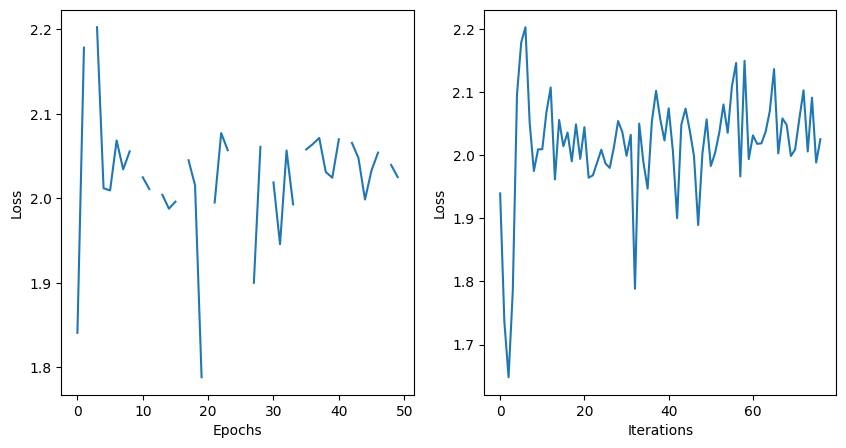

In [151]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))

ax1.plot(epoch_losses)
ax1.set_xlabel("Epochs")
ax1.set_ylabel("Loss")

ax2.plot(iteration_losses)
ax2.set_xlabel("Iterations")
ax2.set_ylabel("Loss")

plt.show()

In [138]:
ori_path = df_results["image_path"][idx]
ori_image = cv2.imread(ori_path)
ori_image = cv2.cvtColor(ori_image, cv2.COLOR_BGR2RGB)

text_list = []
bboxs = df_results["pred_bbox"][idx]

for bbox in bboxs:
    # Crop Image with Bounding Box
    crop_image = ori_image[bbox[1]:bbox[3], bbox[0]:bbox[2]]

    # Convert crop_image to torch tensor
    transform = transforms.Compose([
        transforms.ToPILImage(),
        transforms.ToTensor(),
        transforms.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225))
    ])
    image_tensor = transform(crop_image).unsqueeze(0)

 # Replace this with your actual tensor

    # # Target size
    target_size = (50, 200)

    # Interpolate the tensor to the target size
    resized_tensor = F.interpolate(image_tensor, size=target_size, mode='bilinear', align_corners=False)

    # Change batch size from 1 to 16
    resized_tensor = resized_tensor.expand(16, -1, -1, -1)

print(resized_tensor.size())    

torch.Size([16, 3, 50, 200])


In [169]:
def get_text_crnn(idx, crnn):
    # Assuming crnn_model is an instance of your CRNN class
    crnn.eval()
    
    ori_path = df_results["image_path"][idx]
    ori_image = cv2.imread(ori_path)
    ori_image = cv2.cvtColor(ori_image, cv2.COLOR_BGR2RGB)

    text_list = []
    bboxs = df_results["pred_bbox"][idx]

    for bbox in bboxs:
        # Crop Image with Bounding Box
        crop_image = ori_image[bbox[1]:bbox[3], bbox[0]:bbox[2]]

        # Convert crop_image to torch tensor
        transform = transforms.Compose([
            transforms.ToPILImage(),
            transforms.ToTensor(),
            transforms.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225))
        ])
        image_tensor = transform(crop_image).unsqueeze(0)

        target_size = (50, 200)

        # Interpolate the tensor to the target size
        resized_tensor = F.interpolate(image_tensor, size=target_size, mode='bilinear', align_corners=False)

        # Change batch size from 1 to 16
        resized_tensor = resized_tensor.expand(16, -1, -1, -1)

        # Send the image to the specified device
        resized_tensor = resized_tensor.to(device)

        # Perform OCR using CRNN model
        with torch.no_grad():
            preds = crnn(resized_tensor)

        # Convert the predictions to text
        _, preds_index = preds.max(2)
        preds_str = ''.join([chr(preds_index[0][i] + ord('0')) for i in range(preds_index.size(1))])

        # Clean Text
        del_punc_list = [" ", "·", ":", "-"]
        clean_text = re.sub(r"[ ·:-]", "", preds_str)
        clean_text = clean_text.replace("O", "0")
        clean_text = clean_text.replace("I", "1")
        clean_text = clean_text.upper()
        text_list.append(clean_text)

    return text_list

# Use the modified function
# idx = 1  # Replace with the desired index
# text_result = get_text_crnn(idx, crnn_model, device=device)
# print("Recognized Text:", text_result)

In [170]:
idxs = list(np.arange(0, 250))
text_results = tqdm([get_text_crnn(idx,crnn) for idx in idxs])
text_results = [text[0] if len(text)>0 else "" for text in text_results]
df_results["pred_plate_number"] = text_results
df_results

  0%|          | 0/250 [00:00<?, ?it/s]

,image_path,sub,decoded_plate_number,x1_bbox,y1_bbox,x2_bbox,y2_bbox,pred_bbox,confidence,pred_plate_number
0,C:/Users/User/DeepLearning/Deep_Learning/final...,ccpd_weather,鄂AT2W80,176,497,455,595,"[[177, 493, 454, 597]]",[0.94],2222222222222222
1,C:/Users/User/DeepLearning/Deep_Learning/final...,ccpd_weather,皖AB967N,213,444,469,551,"[[212, 443, 469, 551]]",[0.94],2222222222222222
2,C:/Users/User/DeepLearning/Deep_Learning/final...,ccpd_weather,皖A25T29,257,384,525,486,"[[255, 385, 523, 487]]",[0.93],2222222222222222
3,C:/Users/User/DeepLearning/Deep_Learning/final...,ccpd_weather,皖AZW108,201,476,493,570,"[[198, 476, 490, 570]]",[0.93],2222222222222222
4,C:/Users/User/DeepLearning/Deep_Learning/final...,ccpd_weather,皖AZ2744,252,586,532,684,"[[255, 587, 529, 680]]",[0.95],2222222222222222
...,...,...,...,...,...,...,...,...,...,...
245,C:/Users/User/DeepLearning/Deep_Learning/final...,ccpd_weather,皖AR8T97,96,584,372,688,"[[95, 584, 372, 687]]",[0.93],2222222222222222
246,C:/Users/User/DeepLearning/Deep_Learning/final...,ccpd_weather,皖AL6M60,265,514,533,621,"[[268, 515, 530, 620]]",[0.95],2222222222222222
247,C:/Users/User/DeepLearning/Deep_Learning/final...,ccpd_weather,皖A576X9,282,536,566,637,"[[277, 534, 570, 638]]",[0.92],2222222222222222
248,C:/Users/User/DeepLearning/Deep_Learning/final...,ccpd_weather,皖ALF155,64,606,309,723,"[[62, 606, 307, 721]]",[0.94],2222222222222222
